In [1]:
DEBUG = False

In [2]:
# pip install timm

In [3]:
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [4]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [5]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import timm
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
from torch.cuda.amp import GradScaler



# Config

In [6]:
data_dir = './data'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'how_to_train_skresnet34_b0_to_get_LB_0.86_nolrsch'

enet_type = 'efficientnet-b0'
fold = 1
tile_size = 256
image_size = 256
n_tiles = 34
batch_size = 8
num_workers = 16
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 70
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

./data/train_images


# Create Folds

In [7]:
skf = StratifiedKFold(2, shuffle=True, random_state = 42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1


# Model

In [8]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

    
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = backbone
        self.myfc = nn.Linear(self.enet.fc.in_features, out_dim)
        self.enet.fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

# Dataset

In [9]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [10]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

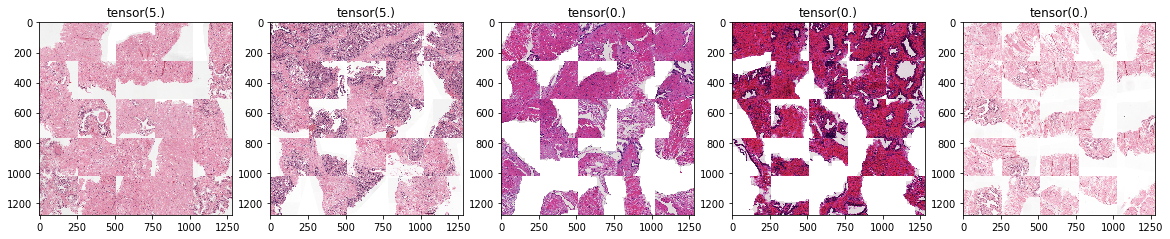

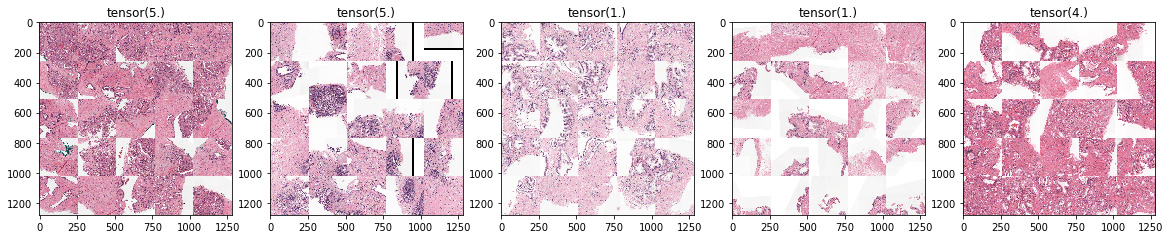

In [11]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [12]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [13]:
def train_epoch(loader, optimizer):

    model.train()
    #model.apply(freeze_bn)
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(data)
            loss = loss_func(logits, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [14]:
enet_type

'efficientnet-b0'

In [15]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)


model = timm.create_model('skresnet34', pretrained=True)

enet_type = model
model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=init_lr/warmup_factor)
# scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
# scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

5308 5308


In [16]:
model.avg_pool = GeM()


# Run Training

In [17]:
%%time

scaler = GradScaler()

qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
#     scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

Sat Jul 11 12:34:33 2020 Epoch: 1



qwk 0.7512309089103136 qwk_k 0.7504237072280167 qwk_r 0.6908347345223051
Sat Jul 11 12:49:13 2020 Epoch 1, lr: 0.0000300, train loss: 0.40566, val loss: 0.30688, acc: 44.15976, qwk: 0.75123
score2 (0.000000 --> 0.751231).  Saving model ...
Sat Jul 11 12:49:13 2020 Epoch: 2



qwk 0.7498555021129323 qwk_k 0.7732939351133132 qwk_r 0.6527636899891143
Sat Jul 11 13:03:57 2020 Epoch 2, lr: 0.0000300, train loss: 0.31948, val loss: 0.30424, acc: 40.91937, qwk: 0.74986
Sat Jul 11 13:03:57 2020 Epoch: 3



qwk 0.8136766482050728 qwk_k 0.8178004215749733 qwk_r 0.763468482000209
Sat Jul 11 13:18:41 2020 Epoch 3, lr: 0.0000300, train loss: 0.29590, val loss: 0.26595, acc: 53.42879, qwk: 0.81368
score2 (0.751231 --> 0.813677).  Saving model ...
Sat Jul 11 13:18:41 2020 Epoch: 4



qwk 0.7978725317849686 qwk_k 0.824524374609381 qwk_r 0.7351254756677219
Sat Jul 11 13:33:23 2020 Epoch 4, lr: 0.0000300, train loss: 0.27331, val loss: 0.26743, acc: 55.10550, qwk: 0.79787
Sat Jul 11 13:33:23 2020 Epoch: 5



qwk 0.8283026977307855 qwk_k 0.8275225396674758 qwk_r 0.7880348568027651
Sat Jul 11 13:48:06 2020 Epoch 5, lr: 0.0000300, train loss: 0.25811, val loss: 0.25114, acc: 58.64732, qwk: 0.82830
score2 (0.813677 --> 0.828303).  Saving model ...
Sat Jul 11 13:48:06 2020 Epoch: 6



qwk 0.8205214080822344 qwk_k 0.8221426422103684 qwk_r 0.7737466714841659
Sat Jul 11 14:02:50 2020 Epoch 6, lr: 0.0000300, train loss: 0.24223, val loss: 0.27673, acc: 52.07234, qwk: 0.82052
Sat Jul 11 14:02:50 2020 Epoch: 7



qwk 0.8277954948593705 qwk_k 0.8404087948373141 qwk_r 0.7716038563840832
Sat Jul 11 14:17:35 2020 Epoch 7, lr: 0.0000300, train loss: 0.23347, val loss: 0.24603, acc: 57.00829, qwk: 0.82780
Sat Jul 11 14:17:35 2020 Epoch: 8



qwk 0.8446441987443889 qwk_k 0.86098283657837 qwk_r 0.7884167086669673
Sat Jul 11 14:32:18 2020 Epoch 8, lr: 0.0000300, train loss: 0.22222, val loss: 0.24345, acc: 57.72419, qwk: 0.84464
score2 (0.828303 --> 0.844644).  Saving model ...
Sat Jul 11 14:32:19 2020 Epoch: 9



qwk 0.8157057002037968 qwk_k 0.8231315050263754 qwk_r 0.7755903975598127
Sat Jul 11 14:47:02 2020 Epoch 9, lr: 0.0000300, train loss: 0.21008, val loss: 0.26087, acc: 60.83271, qwk: 0.81571
Sat Jul 11 14:47:02 2020 Epoch: 10



qwk 0.8327840800952733 qwk_k 0.8430722453284655 qwk_r 0.7859515886465961
Sat Jul 11 15:01:43 2020 Epoch 10, lr: 0.0000300, train loss: 0.19690, val loss: 0.27491, acc: 56.93293, qwk: 0.83278
Sat Jul 11 15:01:43 2020 Epoch: 11



qwk 0.8460885439459492 qwk_k 0.8482666019658702 qwk_r 0.8116851081096543
Sat Jul 11 15:16:25 2020 Epoch 11, lr: 0.0000300, train loss: 0.18985, val loss: 0.24421, acc: 57.34740, qwk: 0.84609
score2 (0.844644 --> 0.846089).  Saving model ...
Sat Jul 11 15:16:26 2020 Epoch: 12



qwk 0.8283165034546561 qwk_k 0.820735318389065 qwk_r 0.793091587808831
Sat Jul 11 15:31:09 2020 Epoch 12, lr: 0.0000300, train loss: 0.18580, val loss: 0.24750, acc: 60.87038, qwk: 0.82832
Sat Jul 11 15:31:09 2020 Epoch: 13



qwk 0.845614163712056 qwk_k 0.8437369630459594 qwk_r 0.8147937756746365
Sat Jul 11 15:45:51 2020 Epoch 13, lr: 0.0000300, train loss: 0.17631, val loss: 0.24750, acc: 61.66164, qwk: 0.84561
Sat Jul 11 15:45:51 2020 Epoch: 14



qwk 0.8447042991728861 qwk_k 0.843992757432393 qwk_r 0.8124941286298666
Sat Jul 11 16:00:36 2020 Epoch 14, lr: 0.0000300, train loss: 0.16435, val loss: 0.24547, acc: 59.55162, qwk: 0.84470
Sat Jul 11 16:00:36 2020 Epoch: 15



qwk 0.8449818650009993 qwk_k 0.8537492544512925 qwk_r 0.801716642670909
Sat Jul 11 16:15:18 2020 Epoch 15, lr: 0.0000300, train loss: 0.16101, val loss: 0.24929, acc: 63.56443, qwk: 0.84498
Sat Jul 11 16:15:18 2020 Epoch: 16



qwk 0.8318798961126713 qwk_k 0.8268800082822799 qwk_r 0.7986103661004456
Sat Jul 11 16:30:03 2020 Epoch 16, lr: 0.0000300, train loss: 0.15272, val loss: 0.26781, acc: 63.07460, qwk: 0.83188
Sat Jul 11 16:30:03 2020 Epoch: 17



qwk 0.8534525077888266 qwk_k 0.8656241388884455 qwk_r 0.8154398475668356
Sat Jul 11 16:44:48 2020 Epoch 17, lr: 0.0000300, train loss: 0.14583, val loss: 0.25011, acc: 62.60362, qwk: 0.85345
score2 (0.846089 --> 0.853453).  Saving model ...
Sat Jul 11 16:44:48 2020 Epoch: 18



qwk 0.8492948642308584 qwk_k 0.8481673615351124 qwk_r 0.8153887317703313
Sat Jul 11 16:59:32 2020 Epoch 18, lr: 0.0000300, train loss: 0.14334, val loss: 0.26032, acc: 60.53127, qwk: 0.84929
Sat Jul 11 16:59:32 2020 Epoch: 19



qwk 0.8536864715427979 qwk_k 0.8569526548094581 qwk_r 0.8211159762376106
Sat Jul 11 17:14:15 2020 Epoch 19, lr: 0.0000300, train loss: 0.13950, val loss: 0.24842, acc: 64.18613, qwk: 0.85369
score2 (0.853453 --> 0.853686).  Saving model ...
Sat Jul 11 17:14:16 2020 Epoch: 20



qwk 0.8556825228604017 qwk_k 0.8595688508810962 qwk_r 0.8209919691713828
Sat Jul 11 17:28:58 2020 Epoch 20, lr: 0.0000300, train loss: 0.12894, val loss: 0.25037, acc: 64.39337, qwk: 0.85568
score2 (0.853686 --> 0.855683).  Saving model ...
Sat Jul 11 17:28:59 2020 Epoch: 21



qwk 0.8614416833860602 qwk_k 0.8660664316589486 qwk_r 0.8296020628569183
Sat Jul 11 17:43:41 2020 Epoch 21, lr: 0.0000300, train loss: 0.12289, val loss: 0.24168, acc: 65.20347, qwk: 0.86144
score2 (0.855683 --> 0.861442).  Saving model ...
Sat Jul 11 17:43:42 2020 Epoch: 22



qwk 0.8636677948240068 qwk_k 0.8691415281546182 qwk_r 0.8299424221621668
Sat Jul 11 17:58:24 2020 Epoch 22, lr: 0.0000300, train loss: 0.11833, val loss: 0.24853, acc: 63.96006, qwk: 0.86367
score2 (0.861442 --> 0.863668).  Saving model ...
Sat Jul 11 17:58:24 2020 Epoch: 23



qwk 0.8695663816817379 qwk_k 0.8684830679289457 qwk_r 0.8428920594773459
Sat Jul 11 18:13:09 2020 Epoch 23, lr: 0.0000300, train loss: 0.11263, val loss: 0.24974, acc: 65.65561, qwk: 0.86957
score2 (0.863668 --> 0.869566).  Saving model ...
Sat Jul 11 18:13:09 2020 Epoch: 24



qwk 0.8598315210447869 qwk_k 0.8603277234411912 qwk_r 0.8292175193157514
Sat Jul 11 18:27:53 2020 Epoch 24, lr: 0.0000300, train loss: 0.11082, val loss: 0.26181, acc: 65.80633, qwk: 0.85983
Sat Jul 11 18:27:53 2020 Epoch: 25



qwk 0.8677857316170842 qwk_k 0.8627557004557868 qwk_r 0.8460522900733828
Sat Jul 11 18:42:34 2020 Epoch 25, lr: 0.0000300, train loss: 0.10058, val loss: 0.25144, acc: 65.63677, qwk: 0.86779
Sat Jul 11 18:42:34 2020 Epoch: 26



qwk 0.8664714870590029 qwk_k 0.8702177493833435 qwk_r 0.8360404318527848
Sat Jul 11 18:57:19 2020 Epoch 26, lr: 0.0000300, train loss: 0.09653, val loss: 0.25941, acc: 66.59759, qwk: 0.86647
Sat Jul 11 18:57:19 2020 Epoch: 27



qwk 0.8331475113745661 qwk_k 0.8422638235360402 qwk_r 0.7850054671837555
Sat Jul 11 19:12:01 2020 Epoch 27, lr: 0.0000300, train loss: 0.08902, val loss: 0.32241, acc: 60.85154, qwk: 0.83315
Sat Jul 11 19:12:01 2020 Epoch: 28



qwk 0.8353031010235938 qwk_k 0.8319044361758634 qwk_r 0.8021070901600579
Sat Jul 11 19:26:44 2020 Epoch 28, lr: 0.0000300, train loss: 0.09798, val loss: 0.32165, acc: 57.66767, qwk: 0.83530
Sat Jul 11 19:26:44 2020 Epoch: 29



qwk 0.8561532584009014 qwk_k 0.8545016009654507 qwk_r 0.8238579876422243
Sat Jul 11 19:41:27 2020 Epoch 29, lr: 0.0000300, train loss: 0.08732, val loss: 0.27819, acc: 64.50641, qwk: 0.85615
Sat Jul 11 19:41:27 2020 Epoch: 30



qwk 0.8704774683982347 qwk_k 0.8676597143062851 qwk_r 0.8429063789141542
Sat Jul 11 19:56:11 2020 Epoch 30, lr: 0.0000300, train loss: 0.08676, val loss: 0.28147, acc: 66.23964, qwk: 0.87048
score2 (0.869566 --> 0.870477).  Saving model ...
Sat Jul 11 19:56:11 2020 Epoch: 31



qwk 0.8701300412569195 qwk_k 0.8620823820071146 qwk_r 0.8444350998207537
Sat Jul 11 20:10:53 2020 Epoch 31, lr: 0.0000300, train loss: 0.08106, val loss: 0.27084, acc: 66.91786, qwk: 0.87013
Sat Jul 11 20:10:53 2020 Epoch: 32



qwk 0.8564992866846217 qwk_k 0.8448163860899837 qwk_r 0.8333388432298912
Sat Jul 11 20:25:36 2020 Epoch 32, lr: 0.0000300, train loss: 0.07494, val loss: 0.27802, acc: 64.73248, qwk: 0.85650
Sat Jul 11 20:25:36 2020 Epoch: 33



qwk 0.801357184228105 qwk_k 0.793689361112553 qwk_r 0.7612236601186553
Sat Jul 11 20:40:19 2020 Epoch 33, lr: 0.0000300, train loss: 0.07410, val loss: 0.36812, acc: 55.91560, qwk: 0.80136
Sat Jul 11 20:40:19 2020 Epoch: 34



qwk 0.8565466584973527 qwk_k 0.8569124257899734 qwk_r 0.8243815585653695
Sat Jul 11 20:55:02 2020 Epoch 34, lr: 0.0000300, train loss: 0.07396, val loss: 0.29910, acc: 66.67295, qwk: 0.85655
Sat Jul 11 20:55:02 2020 Epoch: 35



qwk 0.8644254725609981 qwk_k 0.8663735849212763 qwk_r 0.8309651004996506
Sat Jul 11 21:09:45 2020 Epoch 35, lr: 0.0000300, train loss: 0.06849, val loss: 0.28925, acc: 66.33384, qwk: 0.86443
Sat Jul 11 21:09:45 2020 Epoch: 36



qwk 0.8473612786980269 qwk_k 0.8399470949918458 qwk_r 0.8172225665422981
Sat Jul 11 21:24:27 2020 Epoch 36, lr: 0.0000300, train loss: 0.06402, val loss: 0.33148, acc: 60.79503, qwk: 0.84736
Sat Jul 11 21:24:27 2020 Epoch: 37



qwk 0.8679661840606954 qwk_k 0.8669659065674412 qwk_r 0.8401631072056966
Sat Jul 11 21:39:11 2020 Epoch 37, lr: 0.0000300, train loss: 0.06475, val loss: 0.29189, acc: 67.14393, qwk: 0.86797
Sat Jul 11 21:39:11 2020 Epoch: 38



qwk 0.8336014276697262 qwk_k 0.8168238825244876 qwk_r 0.8069485248536712
Sat Jul 11 21:53:54 2020 Epoch 38, lr: 0.0000300, train loss: 0.06649, val loss: 0.34628, acc: 64.84552, qwk: 0.83360
Sat Jul 11 21:53:54 2020 Epoch: 39



qwk 0.8616576338684049 qwk_k 0.863369216955493 qwk_r 0.8253699724055455
Sat Jul 11 22:08:36 2020 Epoch 39, lr: 0.0000300, train loss: 0.06244, val loss: 0.29620, acc: 65.42954, qwk: 0.86166
Sat Jul 11 22:08:36 2020 Epoch: 40



qwk 0.8443561916794978 qwk_k 0.8564865236740707 qwk_r 0.7974842770843842
Sat Jul 11 22:23:20 2020 Epoch 40, lr: 0.0000300, train loss: 0.05747, val loss: 0.35405, acc: 61.22833, qwk: 0.84436
Sat Jul 11 22:23:20 2020 Epoch: 41



qwk 0.8619858791506999 qwk_k 0.8601735967634274 qwk_r 0.8310007127149348
Sat Jul 11 22:38:02 2020 Epoch 41, lr: 0.0000300, train loss: 0.05633, val loss: 0.30558, acc: 66.57875, qwk: 0.86199
Sat Jul 11 22:38:02 2020 Epoch: 42



qwk 0.8676214401081087 qwk_k 0.8665923257861327 qwk_r 0.8398096841051826
Sat Jul 11 22:52:45 2020 Epoch 42, lr: 0.0000300, train loss: 0.05469, val loss: 0.29852, acc: 67.35117, qwk: 0.86762
Sat Jul 11 22:52:45 2020 Epoch: 43



qwk 0.8676750435922351 qwk_k 0.8636136464719836 qwk_r 0.8421539266442658
Sat Jul 11 23:07:28 2020 Epoch 43, lr: 0.0000300, train loss: 0.05503, val loss: 0.30608, acc: 66.01356, qwk: 0.86768
Sat Jul 11 23:07:28 2020 Epoch: 44



qwk 0.8464041515902418 qwk_k 0.8432369254467157 qwk_r 0.8182821971609326
Sat Jul 11 23:22:15 2020 Epoch 44, lr: 0.0000300, train loss: 0.05232, val loss: 0.33402, acc: 66.84250, qwk: 0.84640
Sat Jul 11 23:22:15 2020 Epoch: 45



qwk 0.8663120031879415 qwk_k 0.8613525105921552 qwk_r 0.8408653955611611
Sat Jul 11 23:36:57 2020 Epoch 45, lr: 0.0000300, train loss: 0.04499, val loss: 0.30971, acc: 66.03240, qwk: 0.86631
Sat Jul 11 23:36:57 2020 Epoch: 46



qwk 0.8650939073797962 qwk_k 0.8624624896391604 qwk_r 0.8364188981691634
Sat Jul 11 23:51:45 2020 Epoch 46, lr: 0.0000300, train loss: 0.04591, val loss: 0.31986, acc: 67.25697, qwk: 0.86509
Sat Jul 11 23:51:45 2020 Epoch: 47



qwk 0.8697171844290738 qwk_k 0.869047141072113 qwk_r 0.8376691013407094
Sun Jul 12 00:06:24 2020 Epoch 47, lr: 0.0000300, train loss: 0.04778, val loss: 0.33300, acc: 65.88169, qwk: 0.86972
Sun Jul 12 00:06:24 2020 Epoch: 48



qwk 0.8512147198139861 qwk_k 0.8486178447055204 qwk_r 0.8199665434176086
Sun Jul 12 00:21:06 2020 Epoch 48, lr: 0.0000300, train loss: 0.04406, val loss: 0.31437, acc: 65.59910, qwk: 0.85121
Sun Jul 12 00:21:06 2020 Epoch: 49



qwk 0.8569034714217529 qwk_k 0.8590601954828964 qwk_r 0.8224512163365671
Sun Jul 12 00:35:46 2020 Epoch 49, lr: 0.0000300, train loss: 0.04472, val loss: 0.30671, acc: 66.50339, qwk: 0.85690
Sun Jul 12 00:35:46 2020 Epoch: 50



qwk 0.8694306136381413 qwk_k 0.859380870397575 qwk_r 0.8493253637696758
Sun Jul 12 00:50:29 2020 Epoch 50, lr: 0.0000300, train loss: 0.04007, val loss: 0.31388, acc: 66.99322, qwk: 0.86943
Sun Jul 12 00:50:29 2020 Epoch: 51



qwk 0.8649741296709699 qwk_k 0.8624418715570858 qwk_r 0.8376193349821256
Sun Jul 12 01:05:11 2020 Epoch 51, lr: 0.0000300, train loss: 0.03642, val loss: 0.32933, acc: 66.42803, qwk: 0.86497
Sun Jul 12 01:05:11 2020 Epoch: 52



qwk 0.8673695214151675 qwk_k 0.8527014139646689 qwk_r 0.846546046247015
Sun Jul 12 01:19:51 2020 Epoch 52, lr: 0.0000300, train loss: 0.04518, val loss: 0.32491, acc: 67.69028, qwk: 0.86737
Sun Jul 12 01:19:51 2020 Epoch: 53



qwk 0.8745371066145816 qwk_k 0.8669833101953409 qwk_r 0.8537130390652474
Sun Jul 12 01:34:31 2020 Epoch 53, lr: 0.0000300, train loss: 0.03901, val loss: 0.29987, acc: 68.25546, qwk: 0.87454
score2 (0.870477 --> 0.874537).  Saving model ...
Sun Jul 12 01:34:32 2020 Epoch: 54



qwk 0.8742582345475078 qwk_k 0.8679275550437624 qwk_r 0.8507978515906277
Sun Jul 12 01:49:13 2020 Epoch 54, lr: 0.0000300, train loss: 0.03431, val loss: 0.31298, acc: 67.27581, qwk: 0.87426
Sun Jul 12 01:49:13 2020 Epoch: 55



qwk 0.8706924108261003 qwk_k 0.8636330276790662 qwk_r 0.8483425994909896
Sun Jul 12 02:03:53 2020 Epoch 55, lr: 0.0000300, train loss: 0.03677, val loss: 0.32777, acc: 68.48154, qwk: 0.87069
Sun Jul 12 02:03:53 2020 Epoch: 56



qwk 0.8712154744834063 qwk_k 0.8672788024583535 qwk_r 0.8446358286536421
Sun Jul 12 02:18:33 2020 Epoch 56, lr: 0.0000300, train loss: 0.03357, val loss: 0.34333, acc: 67.29465, qwk: 0.87122
Sun Jul 12 02:18:33 2020 Epoch: 57



qwk 0.8514015081911647 qwk_k 0.8455413265863302 qwk_r 0.826026105033589
Sun Jul 12 02:33:14 2020 Epoch 57, lr: 0.0000300, train loss: 0.03092, val loss: 0.36686, acc: 63.52675, qwk: 0.85140
Sun Jul 12 02:33:14 2020 Epoch: 58



qwk 0.8640327159043079 qwk_k 0.8686001559654215 qwk_r 0.8294690694610338
Sun Jul 12 02:47:53 2020 Epoch 58, lr: 0.0000300, train loss: 0.03644, val loss: 0.35251, acc: 66.69179, qwk: 0.86403
Sun Jul 12 02:47:53 2020 Epoch: 59



qwk 0.8795253790413351 qwk_k 0.8730698506735143 qwk_r 0.8569059596517731
Sun Jul 12 03:02:33 2020 Epoch 59, lr: 0.0000300, train loss: 0.03232, val loss: 0.32093, acc: 68.55690, qwk: 0.87953
score2 (0.874537 --> 0.879525).  Saving model ...
Sun Jul 12 03:02:33 2020 Epoch: 60



qwk 0.8755019833944172 qwk_k 0.8664011361259947 qwk_r 0.8533640455337563
Sun Jul 12 03:17:14 2020 Epoch 60, lr: 0.0000300, train loss: 0.03164, val loss: 0.33506, acc: 68.29314, qwk: 0.87550
Sun Jul 12 03:17:14 2020 Epoch: 61



qwk 0.8390872317683665 qwk_k 0.8372078522316907 qwk_r 0.8093860850000331
Sun Jul 12 03:31:53 2020 Epoch 61, lr: 0.0000300, train loss: 0.03050, val loss: 0.40139, acc: 62.62246, qwk: 0.83909
Sun Jul 12 03:31:53 2020 Epoch: 62



qwk 0.843934641858262 qwk_k 0.8365072927448358 qwk_r 0.8141690246178768
Sun Jul 12 03:46:34 2020 Epoch 62, lr: 0.0000300, train loss: 0.03165, val loss: 0.37244, acc: 65.74981, qwk: 0.84393
Sun Jul 12 03:46:34 2020 Epoch: 63



qwk 0.8704625896157963 qwk_k 0.8591910120277291 qwk_r 0.8492681981388659
Sun Jul 12 04:01:14 2020 Epoch 63, lr: 0.0000300, train loss: 0.02804, val loss: 0.35161, acc: 68.51922, qwk: 0.87046
Sun Jul 12 04:01:14 2020 Epoch: 64



qwk 0.8030808734999204 qwk_k 0.8164505691923263 qwk_r 0.7423163271525179
Sun Jul 12 04:15:55 2020 Epoch 64, lr: 0.0000300, train loss: 0.03097, val loss: 0.46626, acc: 60.13564, qwk: 0.80308
Sun Jul 12 04:15:55 2020 Epoch: 65



qwk 0.8657597215985708 qwk_k 0.8573459457600895 qwk_r 0.840064393924511
Sun Jul 12 04:30:35 2020 Epoch 65, lr: 0.0000300, train loss: 0.03344, val loss: 0.34939, acc: 67.74680, qwk: 0.86576
Sun Jul 12 04:30:35 2020 Epoch: 66



qwk 0.8653380453802751 qwk_k 0.8548516038222138 qwk_r 0.8421636837056712
Sun Jul 12 04:45:15 2020 Epoch 66, lr: 0.0000300, train loss: 0.02563, val loss: 0.34229, acc: 68.18011, qwk: 0.86534
Sun Jul 12 04:45:15 2020 Epoch: 67



qwk 0.8721667593996488 qwk_k 0.8628586642896426 qwk_r 0.852027637735516
Sun Jul 12 04:59:56 2020 Epoch 67, lr: 0.0000300, train loss: 0.02509, val loss: 0.35742, acc: 69.17860, qwk: 0.87217
Sun Jul 12 04:59:56 2020 Epoch: 68



qwk 0.8721584410204306 qwk_k 0.8638144684330662 qwk_r 0.8510710452731647
Sun Jul 12 05:14:36 2020 Epoch 68, lr: 0.0000300, train loss: 0.02700, val loss: 0.36821, acc: 68.53806, qwk: 0.87216
Sun Jul 12 05:14:36 2020 Epoch: 69



qwk 0.863246570146184 qwk_k 0.8619538644495887 qwk_r 0.8333824973241137
Sun Jul 12 05:29:16 2020 Epoch 69, lr: 0.0000300, train loss: 0.02835, val loss: 0.35661, acc: 68.12359, qwk: 0.86325
Sun Jul 12 05:29:16 2020 Epoch: 70



qwk 0.8578982008157452 qwk_k 0.8595967276485555 qwk_r 0.8218355543569498
Sun Jul 12 05:43:57 2020 Epoch 70, lr: 0.0000300, train loss: 0.02506, val loss: 0.35604, acc: 65.44838, qwk: 0.85790
CPU times: user 12h 58min 23s, sys: 2h 7min 3s, total: 15h 5min 27s
Wall time: 17h 9min 24s
